# Anomaly detection - Gabbar

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.ensemble import IsolationForest
from sklearn.externals import joblib

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [4]:
pd.set_option('display.precision', 2)
pd.set_option('display.max_columns', None)

In [5]:
random_state = 5
cv = 10

In [6]:
non_training_attributes = ['changeset_id', 'changeset_harmful', 'feature_id', 'feature_type']

## Prepare datasets

In [7]:
labelled_path = '../downloads/anomaly-detection/labelled/'

In [8]:
labelled = pd.read_csv(labelled_path + 'attributes.csv')
print(labelled.shape)

# Sort the dataset randomly.
labelled = labelled.sample(labelled.shape[0], random_state=random_state)
labelled.sample(10)

(2272, 15)


,changeset_id,changeset_harmful,feature_id,feature_type,action_create,action_modify,action_delete,feature_version,highway_tag_created,highway_tag_deleted,highway_value_difference,primary_tags_difference,area_of_feature_bbox,length_of_longest_segment,feature_name_touched
683,47515168,1,185964339,way,0,1,0,5,0,0,0,0,7001.98,0.00e+00,0
2199,45428203,1,193562363,way,0,1,0,5,0,0,0,0,157.14,2.56e-02,0
2004,46477976,1,5639467,relation,0,1,0,4,0,0,0,0,1098.37,0.00e+00,0
389,47643353,1,19152384,way,0,1,0,3,0,0,0,0,1.18,7.00e-03,0
1549,47307997,1,332091899,way,0,1,0,2,0,0,0,0,37047.15,2.74e-01,0
638,47531692,1,37853643,way,0,1,0,11,0,0,0,0,235.31,1.20e-02,0
1564,47307886,1,334204096,way,0,1,0,2,0,0,0,0,28110.97,2.52e-01,0
22,48837544,-1,7541058,way,0,1,0,11,0,0,-2,0,6288.84,8.77e-02,0
495,47540276,1,54380529,way,0,1,0,4,0,0,0,0,1360.13,4.53e-02,0
248,47934663,1,487836190,way,0,1,0,3,0,0,1,0,3540.37,3.22e-02,0


In [9]:
# Drop all duplicate samples.
print('Shape before dropping duplicates: {}'.format(labelled.shape))
labelled = labelled.drop_duplicates(subset=['changeset_id', 'feature_id'])
print('Shape after dropping duplicates: {}'.format(labelled.shape))

Shape before dropping duplicates: (2272, 15)
Shape after dropping duplicates: (2272, 15)


In [10]:
labelled.describe()

,changeset_id,changeset_harmful,feature_id,action_create,action_modify,action_delete,feature_version,highway_tag_created,highway_tag_deleted,highway_value_difference,primary_tags_difference,area_of_feature_bbox,length_of_longest_segment,feature_name_touched
count,2.27e+03,2272.00,2.27e+03,2.27e+03,2272.00,2272.0,2272.00,2272.00,2272.00,2272.00,2272.00,2.27e+03,2272.00,2.27e+03
mean,4.73e+07,0.95,2.75e+08,2.64e-03,1.00,0.0,6.07,0.71,0.36,0.04,0.04,1.66e+07,0.16,4.40e-04
std,6.79e+05,0.31,5.94e+08,5.13e-02,0.05,0.0,5.32,4.34,3.25,2.20,0.24,3.24e+08,1.07,2.10e-02
min,4.48e+07,-1.00,1.73e+05,0.00e+00,0.00,0.0,2.00,0.00,0.00,-26.00,-1.00,0.00e+00,0.00,0.00e+00
25%,4.73e+07,1.00,2.89e+07,0.00e+00,1.00,0.0,3.00,0.00,0.00,0.00,0.00,3.91e+02,0.02,0.00e+00
50%,4.74e+07,1.00,1.48e+08,0.00e+00,1.00,0.0,4.00,0.00,0.00,0.00,0.00,3.24e+03,0.06,0.00e+00
75%,4.75e+07,1.00,3.34e+08,0.00e+00,1.00,0.0,8.00,0.00,0.00,0.00,0.00,2.25e+04,0.11,0.00e+00
max,4.97e+07,1.00,4.85e+09,1.00e+00,1.00,0.0,62.00,42.00,42.00,22.00,3.00,1.28e+10,30.89,1.00e+00


In [11]:
labelled.sum(numeric_only=True)

changeset_id                 1.08e+11
changeset_harmful            2.16e+03
feature_id                   6.24e+11
action_create                6.00e+00
action_modify                2.27e+03
action_delete                0.00e+00
feature_version              1.38e+04
highway_tag_created          1.62e+03
highway_tag_deleted          8.21e+02
highway_value_difference     9.10e+01
primary_tags_difference      8.00e+01
area_of_feature_bbox         3.78e+10
length_of_longest_segment    3.62e+02
feature_name_touched         1.00e+00
dtype: float64

In [12]:
inliers = labelled[labelled['changeset_harmful'] == 1]
print('Total inliers: {}'.format(inliers.shape))

outliers = labelled[labelled['changeset_harmful'] == -1]
print('Total outliers: {}'.format(outliers.shape))

Total inliers: (2217, 15)
Total outliers: (55, 15)


In [13]:
total = labelled.shape[0]

# 80% of the inliers will be used for training.
training = inliers.iloc[0:round(0.8 * total)]
training = training.reset_index(drop=True)
print('Training dataset (only inliers): {}'.format(training.shape))

# 20% of the inliers will be used for validation.
validation = inliers.iloc[round(0.8 * total):]
validation = validation.reset_index(drop=True)
print('Validation dataset (only inliers): {}'.format(validation.shape))

# 100% of the outliers will be used for validation too.
validation = pd.concat([validation, outliers])
validation = validation.reset_index(drop=True)
print('Validation dataset (inliers + outliers): {}'.format(validation.shape))

Training dataset (only inliers): (1818, 15)
Validation dataset (only inliers): (399, 15)
Validation dataset (inliers + outliers): (454, 15)


## Model training

In [14]:
X = training.drop(non_training_attributes, axis=1)
y = training['changeset_harmful']

In [15]:
model = IsolationForest(random_state=random_state)
model.fit(X)

IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=5,
        verbose=0)

In [16]:
training['prediction'] = model.predict(X)
training['score'] = model.decision_function(X)
training.to_csv(labelled_path + 'training-review.csv', index=False)

In [17]:
model_path = '../gabbar/trained/model.pkl'
joblib.dump(model, model_path, compress=True)

['../gabbar/trained/model.pkl']

In [18]:
matrix = confusion_matrix(y, training['prediction'])
matrix = pd.DataFrame(matrix, index=['Labelled harmful', 'Labelled good'], columns=['Predicted harmful', 'Predicted good'])
matrix

,Predicted harmful,Predicted good
Labelled harmful,0,0
Labelled good,182,1636


In [19]:
report = classification_report(y, training['prediction'])
print(report)

             precision    recall  f1-score   support

         -1       0.00      0.00      0.00         0
          1       1.00      0.90      0.95      1818

avg / total       1.00      0.90      0.95      1818



,score
count,1818.00
mean,0.16
std,0.07
min,-0.27
25%,0.17
50%,0.19
75%,0.19
max,0.19


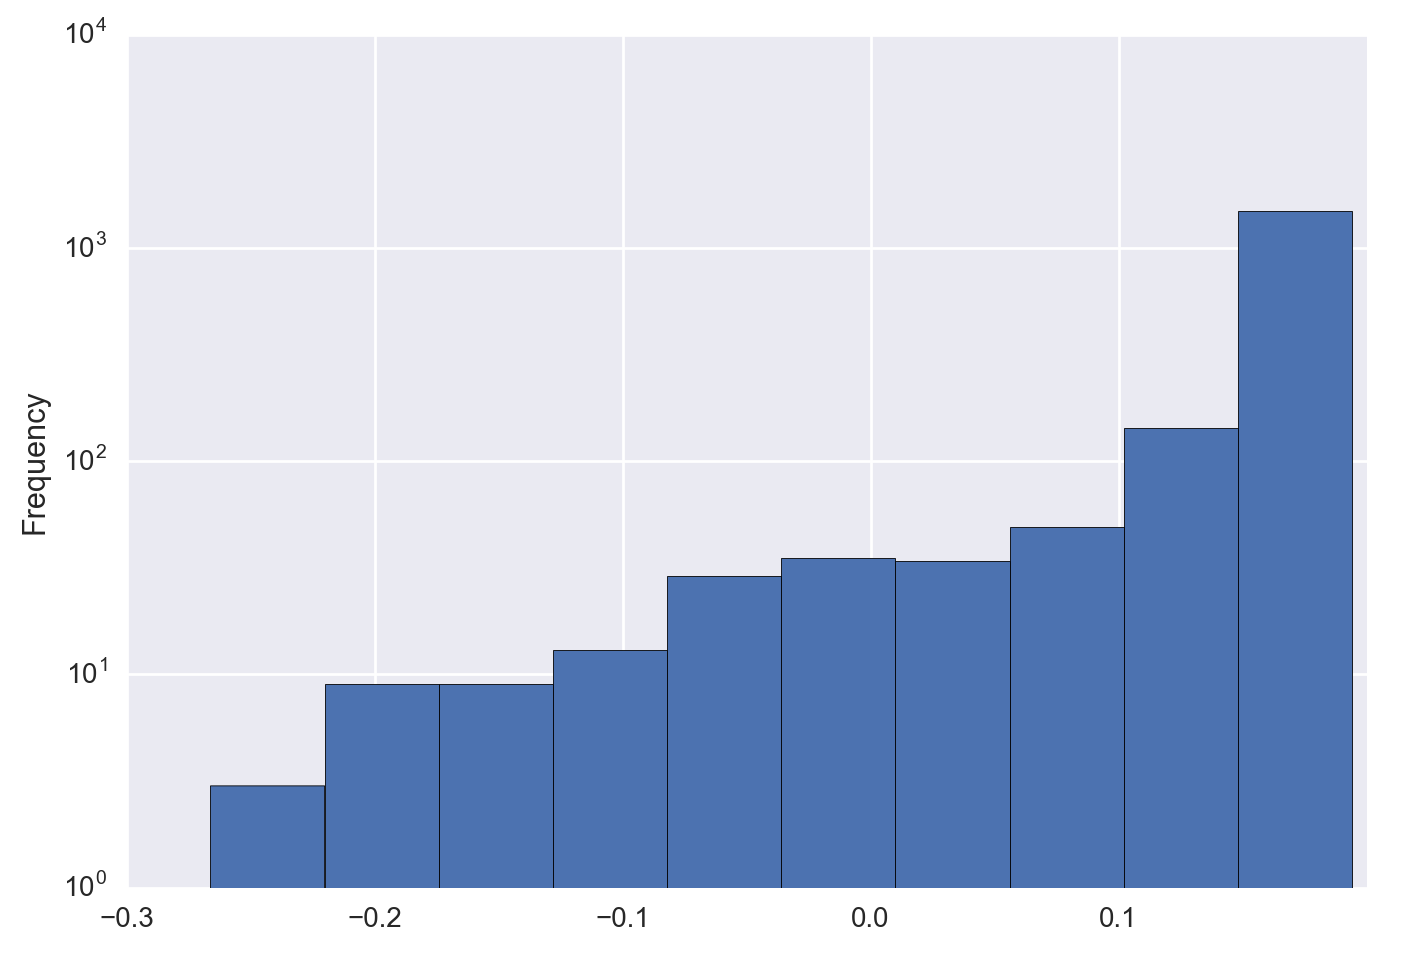

In [20]:
ax = training['score'].plot.hist()
ax.set_yscale('log')

training[['score']].describe()

## Model validation

In [21]:
validation.groupby('changeset_harmful').size()

changeset_harmful
-1     55
 1    399
dtype: int64

In [22]:
vX = validation.drop(non_training_attributes, axis=1)
vy = validation['changeset_harmful']

In [23]:
validation['prediction'] = model.predict(vX)
validation['score'] = model.decision_function(vX)

validation.to_csv(labelled_path + 'validation-review.csv', index=False)

In [24]:
matrix = confusion_matrix(vy, validation['prediction'])
matrix = pd.DataFrame(matrix, index=['Labelled harmful', 'Labelled good'], columns=['Predicted harmful', 'Predicted good'])
matrix

,Predicted harmful,Predicted good
Labelled harmful,36,19
Labelled good,41,358


In [25]:
report = classification_report(vy, validation['prediction'])
print(report)

             precision    recall  f1-score   support

         -1       0.47      0.65      0.55        55
          1       0.95      0.90      0.92       399

avg / total       0.89      0.87      0.88       454



,score
count,454.00
mean,0.14
std,0.09
min,-0.24
25%,0.15
50%,0.18
75%,0.19
max,0.19


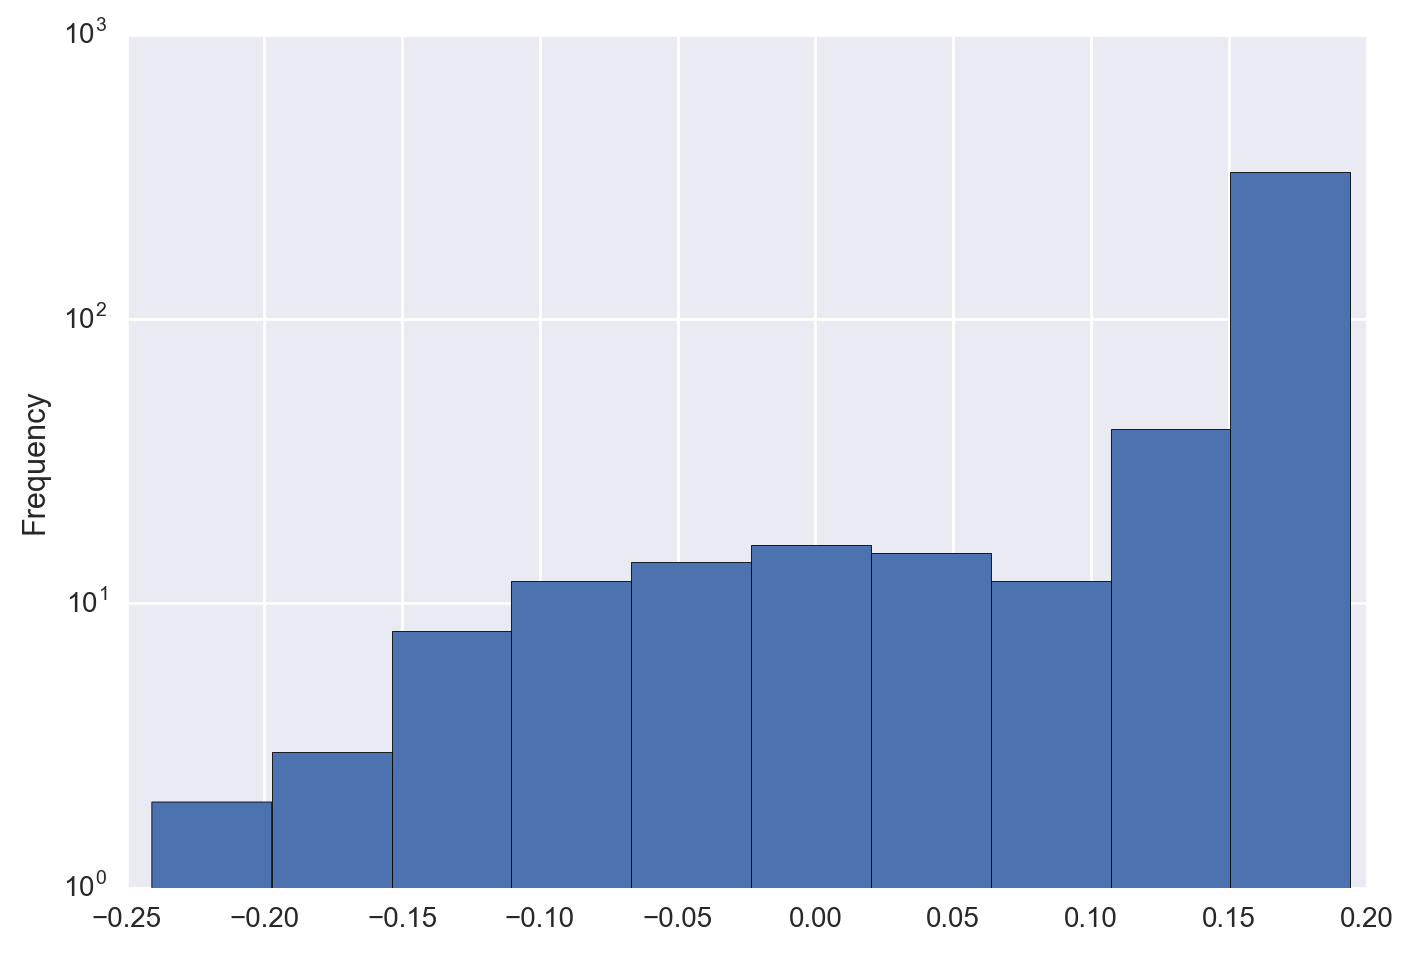

In [26]:
ax = validation['score'].plot.hist()
ax.set_yscale('log')

validation[['score']].describe()

## Model testing

In [27]:
unlabelled_path = testing_path = '../downloads/anomaly-detection/unlabelled/'

In [28]:
unlabelled = pd.read_csv(unlabelled_path + 'attributes.csv')
print(unlabelled.shape)
unlabelled.sample(10)

(288, 15)


,changeset_id,changeset_harmful,feature_id,feature_type,action_create,action_modify,action_delete,feature_version,highway_tag_created,highway_tag_deleted,highway_value_difference,primary_tags_difference,area_of_feature_bbox,length_of_longest_segment,feature_name_touched
170,49173915,NaN,4890387622,node,1,0,0,1,7,0,0,1,0.00,0.00,0
157,49174472,NaN,66730509,way,0,1,0,13,0,0,0,0,32688.76,0.06,0
83,49177219,NaN,49455864,way,0,1,0,9,0,0,0,0,43161.67,0.07,0
93,49176720,NaN,125299795,way,0,1,0,6,0,0,0,0,1066.76,0.17,0
137,49175123,NaN,497489531,way,0,1,0,2,0,0,0,0,14062.08,0.09,0
64,49177883,NaN,437292804,way,0,1,0,3,0,0,0,0,59725.69,0.03,0
81,49177247,NaN,207759084,way,0,1,0,4,0,0,0,0,74643.49,0.06,0
114,49176060,NaN,136990669,way,0,1,0,8,0,0,0,0,156.06,0.07,0
62,49177914,NaN,109724035,way,0,1,0,2,0,0,1,0,20109.72,0.15,0
106,49176254,NaN,383568919,way,0,1,0,2,0,0,0,0,34223.55,0.08,0


In [29]:
# Drop all duplicate samples.
print('Shape before dropping duplicates: {}'.format(unlabelled.shape))
unlabelled = unlabelled.drop_duplicates(subset=['changeset_id', 'feature_id'])
print('Shape after dropping duplicates: {}'.format(unlabelled.shape))

Shape before dropping duplicates: (288, 15)
Shape after dropping duplicates: (288, 15)


In [30]:
# Using all of the unlabelled dataset for testing.
testing = unlabelled.sample(unlabelled.shape[0])

In [31]:
testing.describe()

,changeset_id,changeset_harmful,feature_id,action_create,action_modify,action_delete,feature_version,highway_tag_created,highway_tag_deleted,highway_value_difference,primary_tags_difference,area_of_feature_bbox,length_of_longest_segment,feature_name_touched
count,2.88e+02,0.0,2.88e+02,288.00,288.00,288.00,288.00,288.00,288.00,288.00,288.00,2.88e+02,288.00,288.00
mean,4.92e+07,NaN,5.11e+08,0.04,0.95,0.01,4.67,1.65,1.28,-0.89,0.06,2.69e+06,0.11,0.01
std,2.88e+03,NaN,1.02e+09,0.19,0.22,0.12,3.92,6.43,6.26,4.67,0.37,2.57e+07,0.26,0.12
min,4.92e+07,NaN,4.31e+06,0.00,0.00,0.00,1.00,0.00,0.00,-35.00,-1.00,0.00e+00,0.00,0.00
25%,4.92e+07,NaN,1.03e+08,0.00,1.00,0.00,2.00,0.00,0.00,0.00,0.00,4.09e+02,0.02,0.00
50%,4.92e+07,NaN,3.05e+08,0.00,1.00,0.00,3.00,0.00,0.00,0.00,0.00,4.57e+03,0.05,0.00
75%,4.92e+07,NaN,4.54e+08,0.00,1.00,0.00,5.00,0.00,0.00,0.00,0.00,3.82e+04,0.10,0.00
max,4.92e+07,NaN,4.89e+09,1.00,1.00,1.00,28.00,41.00,37.00,16.00,2.00,4.04e+08,3.02,1.00


In [32]:
testing.sum(numeric_only=True)

changeset_id                 1.42e+10
changeset_harmful            0.00e+00
feature_id                   1.47e+11
action_create                1.10e+01
action_modify                2.73e+02
action_delete                4.00e+00
feature_version              1.34e+03
highway_tag_created          4.74e+02
highway_tag_deleted          3.70e+02
highway_value_difference    -2.57e+02
primary_tags_difference      1.70e+01
area_of_feature_bbox         7.75e+08
length_of_longest_segment    3.24e+01
feature_name_touched         4.00e+00
dtype: float64

In [33]:
tX = testing.drop(non_training_attributes, axis=1)
ty = testing['changeset_harmful']

In [34]:
testing['prediction'] = model.predict(tX)
testing['score'] = model.decision_function(tX)

testing.to_csv(unlabelled_path + 'testing-review.csv', index=False)

In [35]:
tharmful_count = testing[testing['prediction'] == -1].shape[0]
tnot_harmful_count = testing[testing['prediction'] == 1].shape[0]

print('Predicted good: {}'.format(tnot_harmful_count))
print('Predicted harmful: {}'.format(tharmful_count))

print('Percentage harmful: {}%'.format(round(100.0 * tharmful_count / testing.shape[0], 2)))

Predicted good: 221
Predicted harmful: 67
Percentage harmful: 23.26%


,score
count,288.00
mean,0.13
std,0.10
min,-0.20
25%,0.12
50%,0.18
75%,0.19
max,0.19


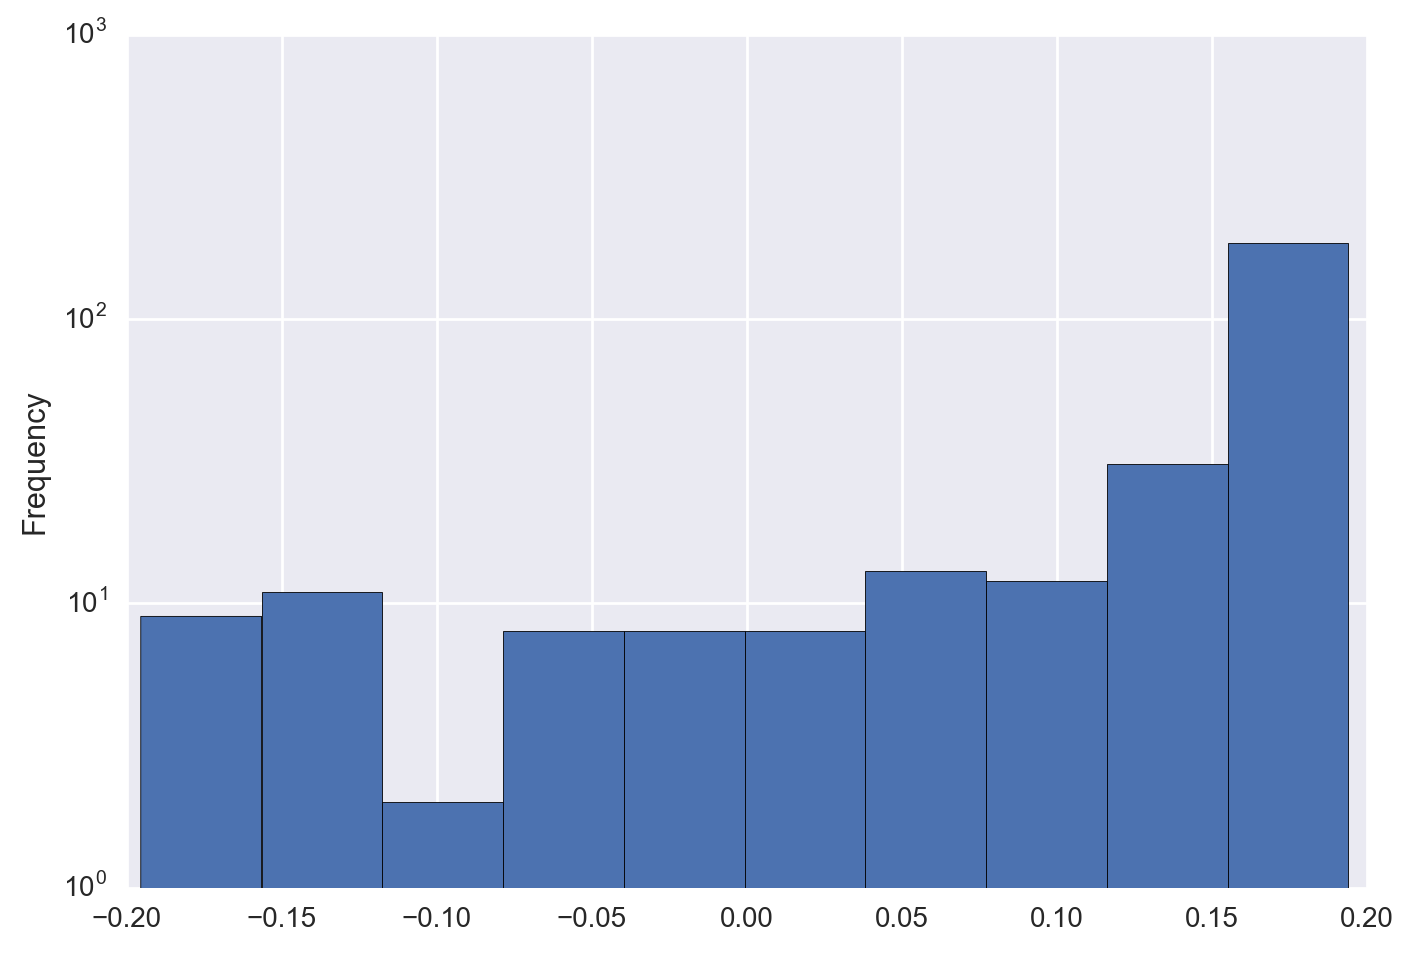

In [36]:
ax = testing['score'].plot.hist()
ax.set_yscale('log')

testing[['score']].describe()